Image loaded and preprocessed successfully.
[0.38431373 0.43529412 0.3372549  ... 0.23137255 0.21568628 0.2901961 ]
Step 0 Cost 1.1235919987304348
Step 20 Cost 0.023802252744274225
Step 40 Cost 0.0007465222528236578
Step 60 Cost 0.00026506214113211337
Step 80 Cost 6.477714085552542e-05
Step 100 Cost 1.2528883900229647e-05
Step 120 Cost 4.523956633510746e-06
Step 140 Cost 2.444421905324113e-06
Step 160 Cost 1.5479326562623228e-06
Step 180 Cost 1.049669080704039e-06
Optimized weights: [[-0.04964126 -0.12156211 -0.03855511 -0.0760888  -0.08706865 -0.09496508
  -0.01709659 -0.08721243 -0.06695485 -0.05823565]
 [-0.03537183 -0.13319678 -0.01463548 -0.10528954 -0.07352023 -0.27436031
  -0.02600358 -0.08192324 -0.0212853  -0.10072631]
 [-0.0569688  -0.11864219 -0.07120963 -0.07356623 -0.09900911 -0.08202923
  -0.0352473  -0.0887901  -0.0588901  -0.05435752]
 [-0.0308599  -0.10495241 -0.0319143  -0.07385969 -0.08092408 -0.2518595
  -0.01769946 -0.07333573 -0.03263013 -0.0743592 ]
 [-0.07448361

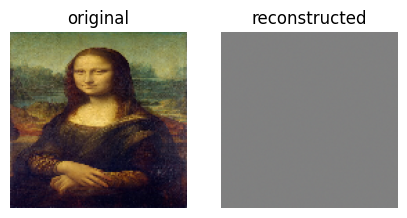

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2
from qiskit import QuantumCircuit , transpile
from qiskit_aer import AerSimulator
import pennylane as qml
from pennylane import numpy as np

import numpy as pop
SIZE = 256

img = cv2.imread( "/home/adminpc/Documents/Professors_Diary/QuantumnComputing/qenv/Qunatumcomputingalgos/Quantumn_image_classification/Images_for_classification/monalisa.jpg"
)

if img is None:
    raise ValueError("Image not found")
else :
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img_data = []
    img_data.append(pop.array(img)) # Using np.array instead of undefined img_to_array
    img_array = pop.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
    img_array = img_array.astype('float32')
    img_array /= 255.0
    flat = img_array.flatten() # flatten data array
    print("Image loaded and preprocessed successfully.")
    print(flat)
#qbt initilization
n_qubits = 10
n_layers = 20

features = flat[:n_qubits]
inputs = (np.pi) * features

dev = qml.device("default.qubit", wires=n_qubits)
# Quantumn Circuit making
@qml.qnode(dev)
def qae(weights):

    # Encode data
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Variational layers
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RY(weights[l,i], wires=i)

        for i in range(0, n_qubits-1, 2):
            qml.CNOT(wires=[i, i+1])

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# -----------------------
# Cost function
# -----------------------
def cost_fn(weights):
    output = qae(weights)
    return np.sum((1 - np.array(output))**2)

# -----------------------
# Training
# -----------------------
weights = 0.01 * np.random.randn(n_layers, n_qubits, requires_grad=True)
opt = qml.AdamOptimizer(0.02)

for step in range(200):
    weights = opt.step(cost_fn, weights)
    if step % 20 == 0:
        print("Step", step, "Cost", cost_fn(weights))

print("Optimized weights:", weights)
print(qae(weights))


from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
# Decoder part of program
# i will be using classical decoder to solve the problem
latent = qae(weights)
latent = np.array(latent).reshape(1, n_qubits)
print(latent.shape)
decoder = models.Sequential([
    layers.Input(shape=(n_qubits,)),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),## OPtimizing batch layers
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(512 , activation="relu"),
    layers.Dense(128*128*3, activation="sigmoid"),
    layers.Reshape((128,128,3))
])
decoder.compile (optimizer = "adam" , loss = "mse")
decoder.fit(latent , img.reshape(1 , 128 , 128 , 3) , epochs = 10, shuffle = True , verbose = 1)
pred = decoder.predict(latent)

plt.figure(figsize =(5 , 5))
plt.subplot(1 ,2 ,1)
plt.title("original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1 ,2 ,2)
plt.title("reconstructed")
plt.imshow(pred[0])
plt.axis("off")
plt.show()
